In [1]:
import numpy as np 
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import datetime
import re

In [2]:
### helper functions ###
datetime_pattern = re.compile(r'^(\S+) (\d+), (\d+)$')

def isdatetimeFormat(string): 
    # isdatetimeFormat(string) checks whether argument has good datetime format which can be converted into datetime object
    # by to_datetime(datelike_string) function. the format is "%b %d, %Y"
    match = datetime_pattern.match(string)
    if not match:
        return False
    month = match.group(1)
    date = int(match.group(2))
    year = int(match.group(3))
    if month not in ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']:
        return False
    elif not( date >0 and date<32):
        return False
    elif year < 0:
        return False
    else: 
        return True

def to_datetime(datelike_string):
    ret = datelike_string[8:] #datelike_string[0:3] + datelike_string[8:]
    ret = datetime.datetime.strptime(ret, "%Y") #(ret, "%b%Y")
    return ret

def is_year_round(string):
    ret = (string == 'Year-round') #or (string=='Rotating')
    return ret

def to_timestamp(datetime_Object):
    return datetime.datetime.timestamp(datetime_Object)

def returnyear(dateObject):
    return dateObject.year

def to_quarter(datetime_Object):
    month = relativedelta(months=+1)
    month2 = relativedelta(months=+2)
    mod = datetime_Object.month % 3
    if mod == 2:
        return datetime_Object - month
    elif mod ==0:
        return datetime_Object - month2
    else: 
        return datetime_Object

In [3]:
### ETL ###

data = pd.read_csv('./data/canadian_data.csv') # read data file

data = data[['ba_score','beer_number','date','style','city','province']] # only keep columns required for analysis
data = data[data['style'].notnull()] 

# figure out top 5 reviewed styles #
count = data[['beer_number','style']] # copying data so I can use original data later; copy subset of data for efficiency.
count = count.rename(columns={'beer_number':'total counts'}).groupby('style').count()
count = count.sort_values(by='total counts', ascending=False)
count = count.head(5)
first = count.index.values[0]  # taking top 5 
second = count.index.values[1]
third = count.index.values[2]
fourth = count.index.values[3]
fifth = count.index.values[4]

# count number of reviews for each beer style for each province #
relative_count = data[['style','province','ba_score']] # once again for efficiency
relative_count = relative_count.merge(count, on='style') # if the review is not for one of top 5 style, it will get filtered out
del relative_count['total counts']
relative_count = relative_count.rename(columns={'ba_score':'counts'}).groupby(['style','province']).count() # group by style and province to count
relative_count = relative_count.unstack(level=0, fill_value=0) # unstack to have provinces as index and styles in column
relative_count = relative_count.drop(['Manitoba','Northwest Territories','Prince Edward Island','Saskatchewan','Yukon']) # deleting province with >= 2 null reviews for styles



# mask1 = relative_count['counts'][first].notnull()
# mask2 = relative_count['counts'][second].notnull()
# mask3 = relative_count['counts'][third].notnull()
# mask4 = relative_count['counts'][fourth].notnull()
# mask5 = relative_count['counts'][fifth].notnull()


/Users/richard/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/Users/richard/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


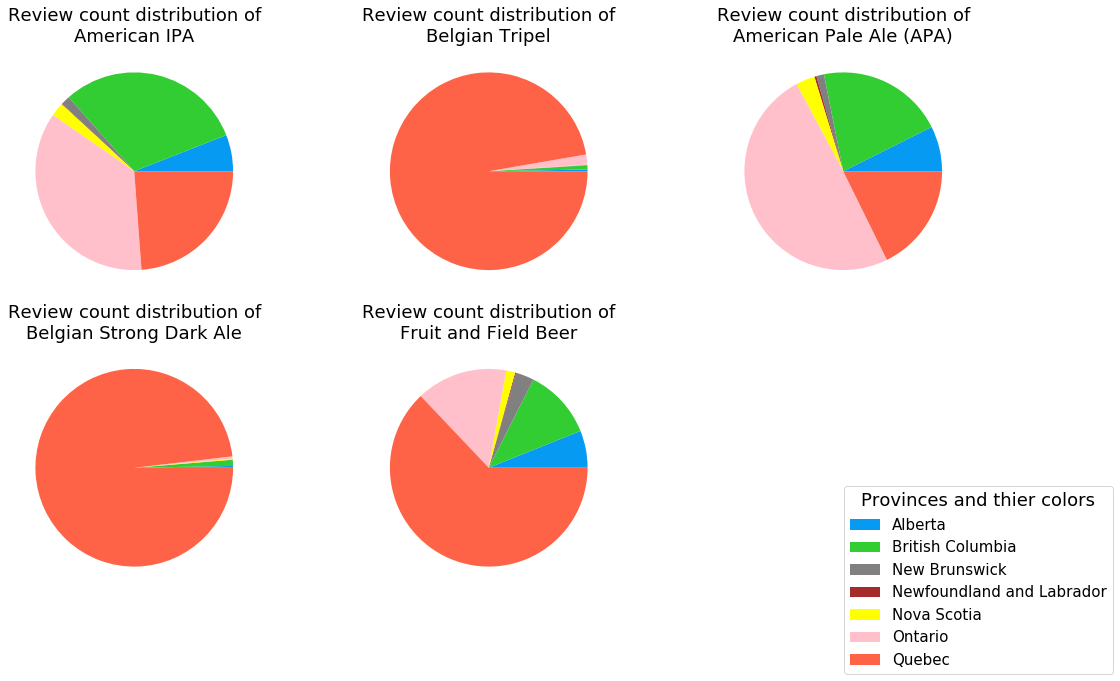

In [4]:
### ploting pie chart ###
# ref1: https://riptutorial.com/matplotlib/example/10473/single-legend-shared-across-multiple-subplots
# ref2: https://stackoverflow.com/questions/38438220/arrangement-of-pie-charts-using-matplotlib-subplot
piece_color=('xkcd:azure','limegreen','grey','brown','yellow','pink','tomato') # Alberta:azure, BC:limegreen, New Brunswick:grey, Newfoundland:brown, NovaScotia:yellow, Ontario:pink, Quebec:tomato
fig = plt.figure(figsize=(18,10))
ax1 = plt.subplot2grid((2,3),(0,0))
plt.pie(relative_count['counts'][first], colors=piece_color)
plt.title('Review count distribution of\n' + first, fontsize=18)
ax2 = plt.subplot2grid((2,3),(0,1))
plt.pie(relative_count['counts'][second], colors=piece_color)
plt.title('Review count distribution of\n' + second, fontsize=18)
ax3 = plt.subplot2grid((2,3),(0,2))
plt.pie(relative_count['counts'][third], colors=piece_color)
plt.title('Review count distribution of\n' + third, fontsize=18)
ax4 = plt.subplot2grid((2,3),(1,0))
plt.pie(relative_count['counts'][fourth], colors=piece_color)
plt.title('Review count distribution of\n'+ fourth, fontsize=18)
ax5 = plt.subplot2grid((2,3),(1,1))
plt.pie(relative_count['counts'][fifth], colors=piece_color)
plt.title('Review count distribution of\n' + fifth, fontsize=18)

fig.legend([ax1, ax2, ax3, ax4, ax5],     # The line objects
           labels=relative_count.index.values,   # The labels for each line
           loc='lower right',   # Position of legend
           borderaxespad=0.5,    # Small spacing around legend box
           title="Provinces and thier colors",  # Title for the legend
           title_fontsize='18',
           prop={'size': 15}
)
plt.savefig('distribution_pie_chart.png')

In [5]:
OUTPUT_TEMPLATE_NORMALITY = (
    'P-value of stats.normaltest results (null hypothesis: input values comes from a normal distribution)\n'
    '    p-value of style ' + first + ' : {p_value1:.3g}\n'
    '    p-value of style ' + second + ' : {p_value2:.3g}\n'
    '    p-value of style ' + third + ' : {p_value3:.3g}\n'
    '    p-value of style ' + fourth + ' : {p_value4:.3g}\n'
    '    p-value of style ' + fifth + ' : {p_value5:.3g}\n'
)
OUTPUT_TEMPLATE_NORMALITY_ONTARIO= (
    'P-value of stats.normaltest results (null hypothesis: input values comes from a normal distribution)\n'
    '    p-value of style ' + first + ' : {p_value1:.3g}\n'
    '    p-value of style ' + second + ' : {p_value2:.3g}\n'
    '    p-value of style ' + third + ' : {p_value3:.3g}\n'
#     '    p-value of style ' + fourth + ' : {p_value4:.3g}\n'
    '    p-value of style ' + fifth + ' : {p_value5:.3g}\n'
)

OUTPUT_TEMPLATE_MANNWHITNEYU = (
    'P-value of stats.mannwhitneyu results (null hypothesis: there is no significant difference between the ba_score given by review given from Ontario and Quebec)\n'
    '    p-value of style ' + first + ' : {p_value1:.3g}\n'
    '    p-value of style ' + second + ' : {p_value2:.3g}\n'
    '    p-value of style ' + third + ' : {p_value3:.3g}\n'
#     '    p-value of style ' + fourth + ' : {p_value4:.3g}\n'
    '    p-value of style ' + fifth + ' : {p_value5:.3g}\n'
)



In [6]:
### Is there mean beer score difference between Quebec and Ontario on each style? ###

# filter top 5 beer styles for ontario reviews organize data # 
new_data = data[['province','style','ba_score']]

ontario_data = new_data[new_data['province']=='Ontario']
ontario_data = ontario_data.merge(count, on='style')

quebec_data = new_data[new_data['province']=='Quebec']
quebec_data = quebec_data.merge(count, on='style')

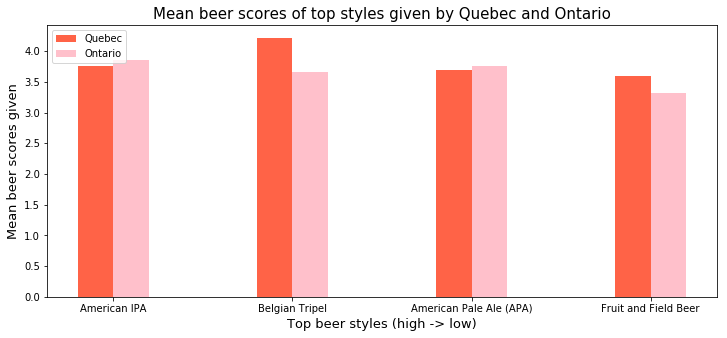

In [7]:
count_check = quebec_data.groupby('style').count()
count_check = count_check[['total counts']].rename(columns={'total counts':'check'})
quebec = quebec_data.groupby('style').mean()
quebec = quebec.join(count_check, on='style')
quebec = quebec[quebec['check']>29]
quebec = quebec.rename(columns={'ba_score':'quebec_score'})

count_check = ontario_data.groupby('style').count()
count_check = count_check[['total counts']].rename(columns={'total counts':'check'})
ontario = ontario_data.groupby('style').mean()
ontario = ontario.join(count_check, on='style')
ontario = ontario[ontario['check']>29]
ontario = ontario.rename(columns={'ba_score':'ontario_score'})

cross_data = quebec[['quebec_score']].join(ontario[['ontario_score']], on='style')
cross_data = cross_data.merge(count, on='style')
cross_data = cross_data[cross_data['ontario_score'].notnull()]
cross_data = cross_data.sort_values(by='total counts', ascending=False)

plt.figure(figsize=(12,5))
X = cross_data.index.values
pos = np.arange(len(X))
bar_width = 0.2
plt.bar(pos, cross_data['quebec_score'], bar_width, color="tomato")
plt.bar(pos+bar_width, cross_data['ontario_score'], bar_width, color='pink')
plt.legend(['Quebec','Ontario'], loc='upper left')
plt.xlabel('Top beer styles (high -> low)', fontsize=13)
plt.ylabel('Mean beer scores given', fontsize=13)
plt.title('Mean beer scores of top styles given by Quebec and Ontario', fontsize=15)
plt.xticks(pos+bar_width/2, X)
plt.savefig('Quebec vs Ontario beer scores.png')
plt.show()

In [8]:
ontario1 = ontario_data[ontario_data['style']==first]
ontario2 = ontario_data[ontario_data['style']==second]
ontario3 = ontario_data[ontario_data['style']==third]
ontario4 = ontario_data[ontario_data['style']==fourth]
ontario5 = ontario_data[ontario_data['style']==fifth]

quebec1 = quebec_data[quebec_data['style']==first]
quebec2 = quebec_data[quebec_data['style']==second]
quebec3 = quebec_data[quebec_data['style']==third]
quebec4 = quebec_data[quebec_data['style']==fourth]
quebec5 = quebec_data[quebec_data['style']==fifth]

# check for normality for both quebec and ontario data #
qb_norm1 = stats.normaltest(quebec1['ba_score'])
qb_norm2 = stats.normaltest(quebec2['ba_score'])
qb_norm3 = stats.normaltest(quebec3['ba_score'])
qb_norm4 = stats.normaltest(quebec4['ba_score'])
qb_norm5 = stats.normaltest(quebec5['ba_score'])
ot_norm1 = stats.normaltest(ontario1['ba_score'])
ot_norm2 = stats.normaltest(ontario2['ba_score'])
ot_norm3 = stats.normaltest(ontario3['ba_score'])
# ot_norm4 = stats.normaltest(ontario4['ba_score'])
ot_norm5 = stats.normaltest(ontario5['ba_score'])
print('Normality of Quebec data:')
print(OUTPUT_TEMPLATE_NORMALITY.format(
    p_value1=qb_norm1.pvalue,
    p_value2=qb_norm2.pvalue,
    p_value3=qb_norm3.pvalue,
    p_value4=qb_norm4.pvalue,
    p_value5=qb_norm5.pvalue
))
print('Normality of Ontario data:')
print(OUTPUT_TEMPLATE_NORMALITY_ONTARIO.format(
    p_value1=ot_norm1.pvalue,
    p_value2=ot_norm2.pvalue,
    p_value3=ot_norm3.pvalue,
#     p_value4=ot_norm4.pvalue,
    p_value5=ot_norm5.pvalue
))

# perform non-parametric test since most of scores are not from a normal dist. #
style1 = stats.mannwhitneyu(quebec1['ba_score'], ontario1['ba_score'], alternative='two-sided')
style2 = stats.mannwhitneyu(quebec2['ba_score'], ontario2['ba_score'], alternative='two-sided')
style3 = stats.mannwhitneyu(quebec3['ba_score'], ontario3['ba_score'], alternative='two-sided')
# style4 = stats.mannwhitneyu(quebec4['ba_score'], ontario4['ba_score'], alternative='two-sided') # ontario has less then 20 values
style5 = stats.mannwhitneyu(quebec5['ba_score'], ontario5['ba_score'], alternative='two-sided') 
print('Difference in mean ba_score given from Ontario vs Quebec')
print(OUTPUT_TEMPLATE_MANNWHITNEYU.format(
    p_value1=style1.pvalue,
    p_value2=style2.pvalue,
    p_value3=style3.pvalue,
#     p_value4=style4.pvalue, # ontario data is > 20
    p_value5=style5.pvalue
))



Normality of Quebec data:
P-value of stats.normaltest results (null hypothesis: input values comes from a normal distribution)
    p-value of style American IPA : 6.04e-81
    p-value of style Belgian Tripel : 2.93e-297
    p-value of style American Pale Ale (APA) : 2.8e-45
    p-value of style Belgian Strong Dark Ale : 2.11e-288
    p-value of style Fruit and Field Beer : 1.34e-88

Normality of Ontario data:
P-value of stats.normaltest results (null hypothesis: input values comes from a normal distribution)
    p-value of style American IPA : 3.69e-159
    p-value of style Belgian Tripel : 0.324
    p-value of style American Pale Ale (APA) : 3.24e-92
    p-value of style Fruit and Field Beer : 1.52e-10

Difference in mean ba_score given from Ontario vs Quebec
P-value of stats.mannwhitneyu results (null hypothesis: there is no significant difference between the ba_score given by review given from Ontario and Quebec)
    p-value of style American IPA : 1.58e-11
    p-value of style Belg

In [9]:
# ontario

In [10]:
# first

In [11]:
# second

In [12]:
# third

In [13]:
# fourth

In [14]:
# fifth